# Korišćene biblioteke
U projektu su korišćene navedene biblioteke.

In [100]:
from sklearn.cluster import KMeans, Birch, MeanShift, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

# Filter uz pomoć mean shift klasterizacije
Ovaj način klasterizacije je pogodan za otkrivanje outlier-a.

In [101]:
def mean_shift_elimination(data, pca_model, min_count, display):
    mshift = MeanShift()
    indexes = mshift.fit_predict(data)
    destinations = mshift.cluster_centers_

    k = destinations.shape[0]

    destinations_count = np.array([(indexes == i).sum() for i in (range(k))])
    print("Mean shift elimination:")
    print(destinations_count)
    destinations_marker = destinations_count >= min_count
    data_marker = destinations_marker[indexes]

    good_data = data[data_marker]
    bad_data = data[np.invert(data_marker)]

    if display:
        good_data_pca = pca_model.transform(good_data)
        if bad_data.shape[0] > 0:
            bad_data_pca = pca_model.transform(bad_data)

        fig = plt.figure()
        axes = Axes3D(fig)
        axes.scatter(good_data_pca[:, 0], good_data_pca[:, 1], good_data_pca[:, 2], color="b")
        if bad_data.shape[0] > 0:
            axes.scatter(bad_data_pca[:, 0], bad_data_pca[:, 1], bad_data_pca[:, 2], color="r")
        plt.show()

    print(destinations_marker.sum())
    return good_data, destinations_marker.sum()

# Filter uz pomoć k-means klasterizacije
Ovaj način klasterizacije se ovde koristi za otkrivanje outlier-a.

In [102]:
def kmeans_elimination(data, pca, k, max_distance, display):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=10000)
    indexes = kmeans.fit_predict(data)
    centers = kmeans.cluster_centers_

    distances = data - centers[indexes]
    data_marker = np.linalg.norm(distances, axis=1) <= max_distance

    good_data = data[data_marker]
    bad_data = data[np.invert(data_marker)]
    good_indexes = indexes[data_marker]

    print("Eliminated via K-means:")
    print(bad_data.shape[0])

    if display:
        good_data_pca = pca.transform(good_data)
        if bad_data.shape[0] > 0:
            bad_data_pca = pca.transform(bad_data)
        centers_pca = pca.transform(centers)

        colors_array = []
        colors_array_dark = []
        for i in range(k):
            colors_array.append(colors.hsv_to_rgb([i/k, 1, 1]))
            colors_array_dark.append(colors.hsv_to_rgb([i/k, 1, 0.2]))

        colors_to_show = np.array(colors_array)[good_indexes]

        fig = plt.figure()
        axes = Axes3D(fig)
        axes.scatter(good_data_pca[:, 0], good_data_pca[:, 1], good_data_pca[:, 2], color=colors_to_show)
        if bad_data.shape[0] > 0:
            axes.scatter(bad_data_pca[:, 0], bad_data_pca[:, 1], bad_data_pca[:, 2], color="black")
        axes.scatter(centers_pca[:, 0], centers_pca[:, 1], centers_pca[:, 2],
                     marker='*', s=250, color=colors_array_dark, label='Cluster centers')
        plt.show()

    return good_data

# Birch klasterizacija je poslednji korak u pipeline-u
Koristi se za finalnu klasterizaciju.

In [103]:
def birch_clustering(data, pca, k):
    birch = Birch(n_clusters=k)
    indexes = birch.fit_predict(data)
    data_pca = pca.fit_transform(data)

    colors_array = []
    colors_array_dark = []
    for i in range(k):
        colors_array.append(colors.hsv_to_rgb([i / k, 1, 1]))
        colors_array_dark.append(colors.hsv_to_rgb([i / k, 1, 0.2]))
    colors_array = np.array(colors_array)

    fig = plt.figure()
    axes = Axes3D(fig)
    axes.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], color=colors_array[indexes])
    plt.show()

# DBSCAN klasterizacija
Ne koristi se u pipeline-u. Pokazalo se je da ovaj način klasterizacije nije pogodan za korišćeni dataset.

In [104]:
def db_scan(data, pca, eps):
    db = DBSCAN(eps=eps, min_samples=10)
    indexes = db.fit_predict(data)
    print("DBSCAN:")
    print(indexes)

    data_pca = pca.fit_transform(data)

    colors_array = []
    colors_array_dark = []

    labels = db.labels_
    k = len(set(labels)) - (1 if -1 in labels else 0)
    for i in range(k):
        colors_array.append(colors.hsv_to_rgb([i / k, 1, 1]))
        colors_array_dark.append(colors.hsv_to_rgb([i / k, 1, 0.2]))

    colors_array = np.array(colors_array)

    fig = plt.figure()
    axes = Axes3D(fig)
    axes.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], color=colors_array[indexes])
    plt.show()

# Glavna metoda
Prvo se vrši selekcija neophodnih atributa.

In [105]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
raw_data = pd.read_csv(data_url)
feature_names = [column for column in raw_data.columns if column not in ["Channel", "Region"]]
data = raw_data[feature_names].to_numpy()

Vrši se priprema PCA objekta koji se kasnije koristi kod vizuelizacije podataka.

In [106]:
pca_model = PCA(n_components=3)
pca_model.fit(data)
print("PCA components:")
print(pca_model.components_)

PCA components:
[[ 0.97653685  0.12118407  0.06154039  0.15236462 -0.00705417  0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]]


Pet puta se primenjuje eliminacija outlier-a preko mean shift klasterizacije.

Mean shift elimination:
[383  12   1   1   1   1   1   2   1  21   1   2   1  12]


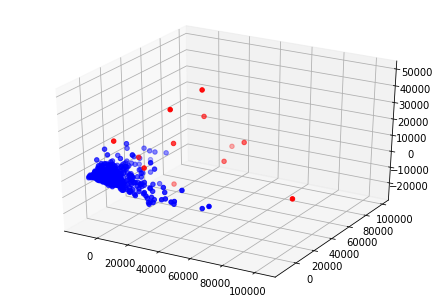

4
Mean shift elimination:
[370   4  30  12  12]


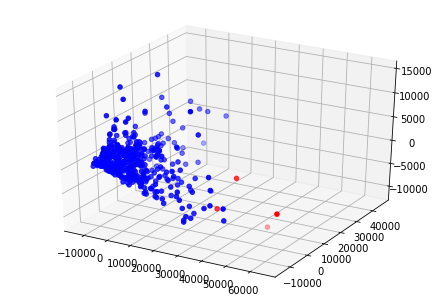

4
Mean shift elimination:
[358  25  30  10   1]


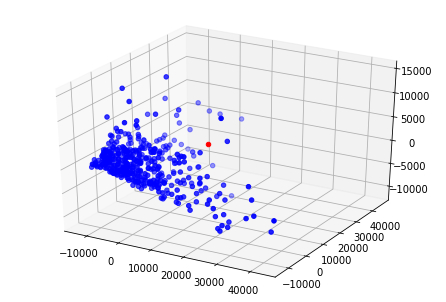

4
Mean shift elimination:
[358  25  30  10]


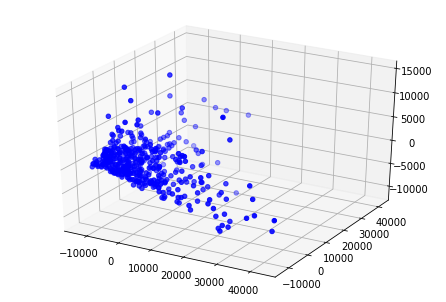

4
Mean shift elimination:
[358  25  30  10]


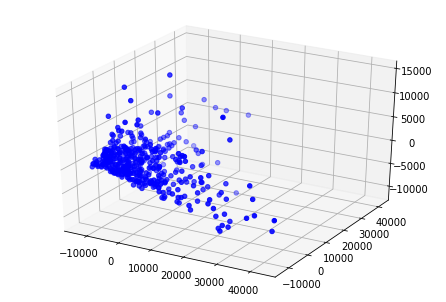

4


In [107]:
clusters = -1
for i in range(5):
    data, clusters = mean_shift_elimination(data, pca_model, 5, display=True)

Pet puta se primenjuje eliminacija outlier-a preko k-means klasterizacije.

Eliminated via K-means:
26


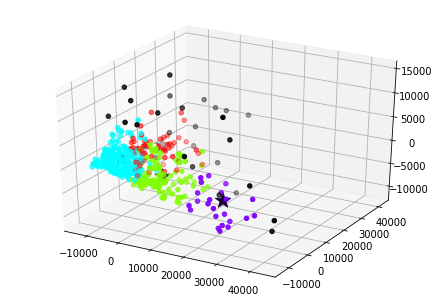

Eliminated via K-means:
11


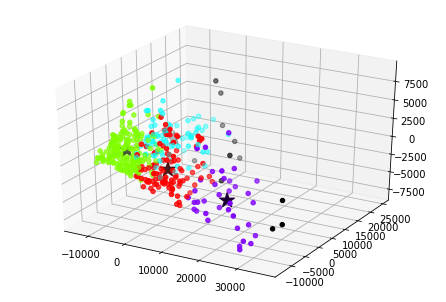

Eliminated via K-means:
3


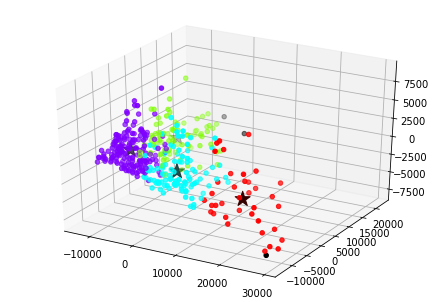

Eliminated via K-means:
0


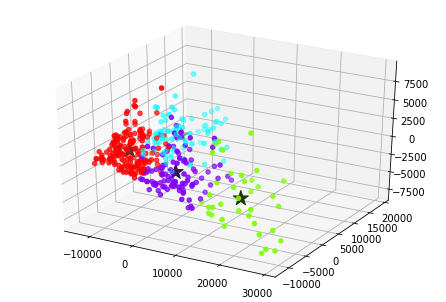

Eliminated via K-means:
0


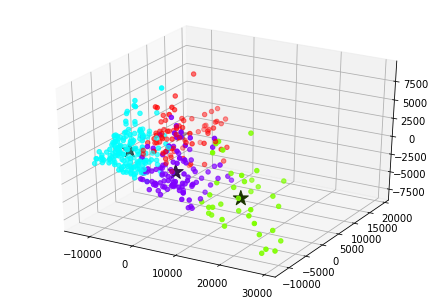

In [108]:
for i in range(5):
    data = kmeans_elimination(data, pca_model, clusters, 13000, display=True)

Vrši se klasterizacija na prečišćenom dataset-u pomoću BIRCH klasterizacije.

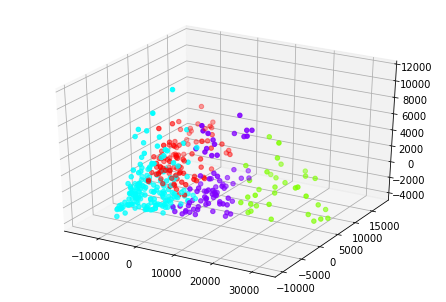

In [109]:
birch_clustering(data, pca_model, int(clusters))